## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd
import emcee
import seaborn as sns
import corner
import bilby

from astropy import cosmology, units
from scipy.interpolate import interp1d

from bilby.core.prior import Uniform, LogUniform, PriorDict

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Loading Posteriors

In [3]:
parameter_translator = dict(
    mass_1_det = 'm1_detector_frame_Msun',
    mass_2_det = 'm2_detector_frame_Msun',
    luminosity_distance = 'luminosity_distance_Mpc',
    a_1 = 'spin1',
    a_2 = 'spin2',
    cos_tilt_1 = 'costilt1',
    cos_tilt_2 = 'costilt2')

In [9]:
posteriors = list()
priors = list()

file = 'GWTC-1_sample_release/GW{}_GWTC-1.hdf5'

events = ['150914', '151012', '151226', '170104', '170608', '170729', '170809', '170814', 
          '170818', '170823']

for event in events:
    _posterior = pd.DataFrame()
    _prior = pd.DataFrame()
    with h5py.File(file.format(event), 'r') as ff:
        for my_key, gwtc_key in parameter_translator.items():
            _posterior[my_key] = ff['Overall_posterior'][gwtc_key]
            _prior[my_key] = ff['prior'][gwtc_key]
    posteriors.append(_posterior)
    priors.append(_prior)

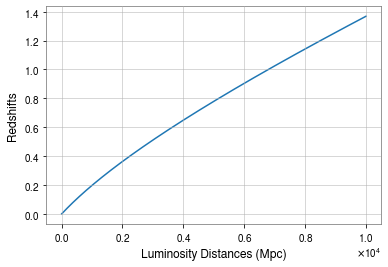

In [10]:
luminosity_distances = np.linspace(1, 10000, 1000)
redshifts = np.array([cosmology.z_at_value(cosmology.Planck15.luminosity_distance, 
                                                   dl * units.Mpc) for dl in luminosity_distances])
dl_to_z = interp1d(luminosity_distances, redshifts)

plt.plot(luminosity_distances, redshifts)
plt.xlabel('Luminosity Distances (Mpc)')
plt.ylabel('Redshifts')
plt.show()

In [11]:
def chieff(a1, a2, m1, m2, cost1, cost2):
    chieff = (a1*m1*cost1 + a2*m2*cost2)/(m1+m2)
    return chieff

In [12]:
for posterior in posteriors:
    posterior['redshift'] = dl_to_z(posterior['luminosity_distance'])
    posterior['mass_1'] = posterior['mass_1_det'] / (1 + posterior['redshift'])
    posterior['mass_2'] = posterior['mass_2_det'] / (1 + posterior['redshift'])
    posterior['mass_ratio'] = posterior['mass_2'] / posterior['mass_1']
    posterior['chieff'] = chieff(posterior['a_1'], posterior['a_2'], 
                                 posterior['mass_1'], posterior['mass_2'], 
                                 posterior['cos_tilt_1'], posterior['cos_tilt_2'])

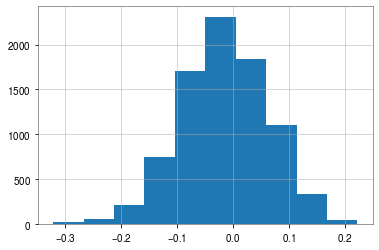

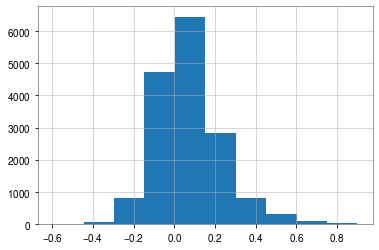

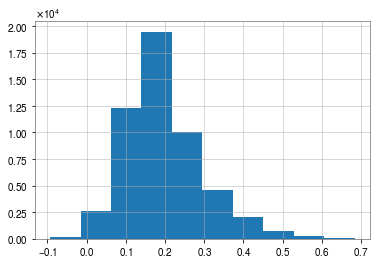

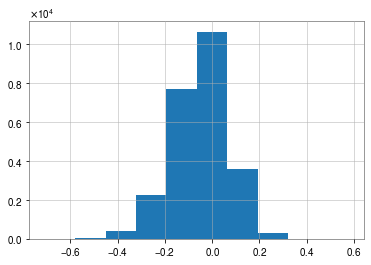

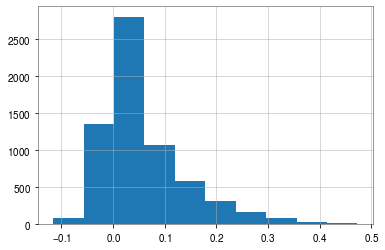

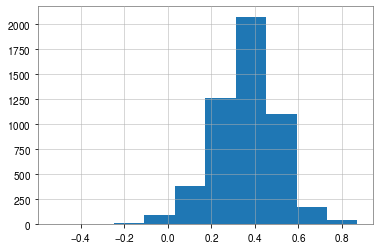

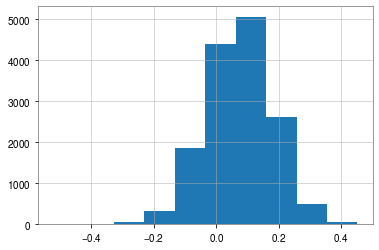

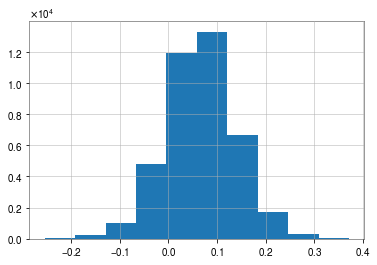

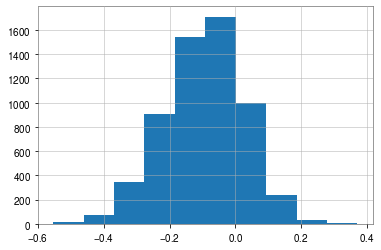

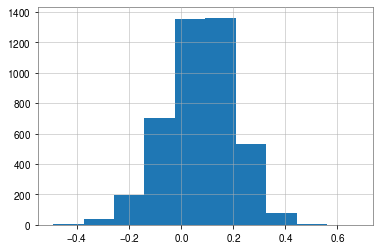

In [16]:
for posterior in posteriors:
    plt.hist(posterior['chieff'], bins=10)
    plt.show()

In [ ]:
# def truncated_gaussian_chieff(data, mu_chieff, sigma_chieff):
#     prob = gwpop.utils.truncnorm(dataset['chieff'], mu=mu_bns, sigma=sigma_bns, low=-1, high=1)
#     return prob

In [13]:
priorsB = PriorDict()

# mass


priorsB['chieff'] = bilby.core.prior.TruncatedGaussian(name='chieff', mu=1, sigma=0.4, 
                                                       minimum=-1, maximum=1, latex_label='$\\chi_{eff}$')
# priorsB['mu'] = bilby.core.prior

# rate
# priorsB['rate'] = LogUniform(minimum=1e-20, maximum=1e20, latex_label='$R$')

# # mass
# full_priors['alpha'] = Uniform(minimum=-4, maximum=12, latex_label='$\\alpha$')
# full_priors['beta'] = Uniform(minimum=-4, maximum=12, latex_label='$\\beta$')
# full_priors['mmin'] = Uniform(minimum=5, maximum=10, latex_label='$m_{\\min}$')
# full_priors['lam'] = Uniform(minimum=0, maximum=1, latex_label='$\\lambda_{m}$')
# full_priors['mpp'] = Uniform(minimum=20, maximum=50, latex_label='$\\mu_{m}$')
# full_priors['sigpp'] = Uniform(minimum=0, maximum=10, latex_label='$\\sigma_{m}$')
# # spin magnitude
# full_priors['amax'] = 1
# full_priors['alpha_chi'] = Uniform(minimum=-4, maximum=12, latex_label='$\\alpha_{\\chi}$')
# full_priors['beta_chi'] = Uniform(minimum=-4, maximum=12, latex_label='$\\beta_{\\chi}$')
# # spin orientation
# full_priors['xi_spin'] = Uniform(minimum=0, maximum=1, latex_label='$\\xi$')
# full_priors['sigma_1'] = Uniform(minimum=0, maximum=4, latex_label='$\\sigma{1}$')
# full_priors['sigma_2'] = Uniform(minimum=0, maximum=4, latex_label='$\\sigma{2}$')
# # redshift evolution
# full_priors['lamb'] = Uniform(minimum=-25, maximum=25, latex_label='$\\lambda_{z}$')

priorsB_samples = priorsB.sample(10000)
priorsB_samples

{'chieff': array([0.83240936, 0.55764203, 0.50476022, ..., 0.47162491,
        0.75759996, 0.89690552])}

In [ ]:
priorsB_samples_array = np.array([priorsB_samples['chieff']).T
corner.corner(prior_samples_array, labels=['x', 'y'])
plt.show()

In [ ]:
modelB = bilby.hyper.model.Model([mass.SinglePeakSmoothedMassDistribution,
                                 spin.iid_spin,
                                 spin.independent_spin_orientation_gaussian_isotropic])

In [ ]:
fast_likelihood = gwpop.hyperpe.RateLikelihood(posteriors=posteriors, hyper_prior=model)

In [ ]:
full_likelihood.parameters.update(full_priors.sample())
full_likelihood.log_likelihood_ratio()

resultB = bilby.run_sampler(likelihood=likelihoodB, priors=priorsB, sampler='emcee', nlive=100)